In [1]:
import os
import sys
import gc
import pandas as pd
import pandas_ta as ta
from math import pi
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
import joblib
import m2cgen as m2c

sys.path.append(os.getcwd() + os.sep + '..' + os.sep + '..' + os.sep + '..')

from pyautotrader.utils.model_export import export_model_python

In [2]:
data_folder = os.path.join('..','00.data','output')

files_found = [x for x in os.listdir(data_folder) if x.endswith('.pickle')]
files_found_tokens=[x.split('.') for x in files_found]

models_found = {}

for current_model in files_found_tokens:
    model_name = '.'.join(current_model[:-2])
    filename = os.path.join('..','00.data','output','.'.join(current_model))
    if not model_name in models_found:
        models_found[model_name]= {}          
    models_found[model_name][current_model[-2]]=filename

print(models_found)

{'WDO.5Min.100.50': {'parameters': '..\\00.data\\output\\WDO.5Min.100.50.parameters.pickle', 'raw': '..\\00.data\\output\\WDO.5Min.100.50.raw.pickle', 'total': '..\\00.data\\output\\WDO.5Min.100.50.total.pickle', 'xgboostlongmodel': '..\\00.data\\output\\WDO.5Min.100.50.xgboostlongmodel.pickle', 'xgboostshortmodel': '..\\00.data\\output\\WDO.5Min.100.50.xgboostshortmodel.pickle'}}


In [3]:
first_model = list(models_found.keys())[0]
current_total_dataset = joblib.load(models_found[first_model]['total'])
current_parameters = joblib.load(models_found[first_model]['parameters'])
current_raw_dataset = joblib.load(models_found[first_model]['raw'])

best_short_booster = joblib.load(models_found[first_model]['xgboostshortmodel'])
best_long_booster = joblib.load(models_found[first_model]['xgboostlongmodel'])

In [4]:
df_current_total_dataset = pd.DataFrame(current_total_dataset)

In [5]:
df_current_total_dataset = df_current_total_dataset[['current_date', 'current_time'] + current_parameters['CURRENT_X_COLUMNS']]

In [6]:
current_total_dataset = None
gc.collect()

46

In [7]:
def predict_short(row):
    a = row[current_parameters['CURRENT_X_COLUMNS']].to_numpy().reshape(1,-1)
    return best_short_booster.inplace_predict(a)[0]

def predict_long(row):
    a = row[current_parameters['CURRENT_X_COLUMNS']].to_numpy().reshape(1,-1)
    return best_long_booster.inplace_predict(a)[0]

df_current_total_dataset['short_predict'] = df_current_total_dataset.apply( lambda row: predict_short(row), axis=1)
df_current_total_dataset['long_predict'] = df_current_total_dataset.apply( lambda row: predict_long(row), axis=1)

<AxesSubplot:>

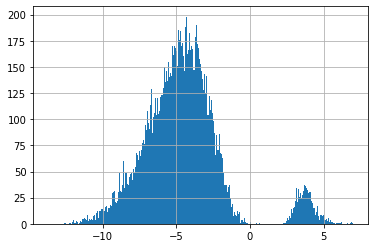

In [8]:
df_current_total_dataset['short_predict'].hist(bins=500)

<AxesSubplot:>

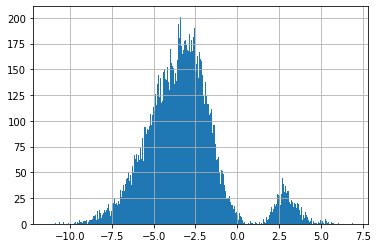

In [9]:
df_current_total_dataset['long_predict'].hist(bins=500)

In [10]:
results_from_df = df_current_total_dataset.to_dict('records')
results = {}
short_results = []
long_results = []

for current_result in results_from_df:
    results[(current_result['current_date'] * 10000) + current_result['current_time']] = \
    { 
        'short_predict' : current_result['short_predict'],
        'long_predict' : current_result['long_predict']
    }    
    short_results.append(current_result['short_predict'])
    long_results.append(current_result['long_predict'])



In [11]:
results_from_df = None
df_current_total_dataset = None
gc.collect()

0

In [12]:
minimum_short_predict = 0
minimum_long_predict = 0

maximum_short_predict = int(round(max(short_results),0))
maximum_long_predict = int(round(max(long_results),0))

current_short_predict = 0
current_long_predict = 0

current_trade = None
current_trade_entries = []

candle_count = 0
current_target = current_parameters['CURRENT_TARGET']
current_stop = current_parameters['CURRENT_STOP']

MAX_TRADE_DURATION = 24

for current_candle in current_raw_dataset:
    if current_trade is not None:
        is_short = current_trade['trade_type'] == 'short'
        is_long = current_trade['trade_type'] == 'long'
        if is_short:
            if current_candle['low'] <= current_trade['trade_target']:
                current_trade['result'] =  current_trade['trade_start'] - current_trade['trade_target']
                current_trade = None
                continue
            if current_candle['high'] >= current_trade['trade_stop']:
                current_trade['result'] =  current_trade['trade_stop'] - current_trade['trade_start']
                current_trade = None
                continue
        if is_long:
            if current_candle['low'] <= current_trade['trade_stop']:
                current_trade['result'] =  current_trade['trade_stop'] - current_trade['trade_start']
                current_trade = None
                continue
            if current_candle['high'] >= current_trade['trade_target']:
                current_trade['result'] =  current_trade['trade_target'] - current_trade['trade_start']
                current_trade = None
                continue
        if candle_count > (current_trade['start_candle'] + MAX_TRADE_DURATION):
            if is_long:
                current_trade['result'] =  current_trade['close'] - current_trade['trade_start']
            if is_short:
                current_trade['result'] =  current_trade['trade_start'] - current_trade['close']
            current_trade = None
            continue
        
    if current_trade is None:
        if current_candle['Date'] > current_parameters['MINIMUM_DATE_TRADE'] and \
           current_candle['Time'] >= current_parameters['MINIMUM_TIME'] and \
           current_candle['Time'] <= current_parameters['MAXIMUM_TIME']:
            current_date_time = (current_candle['Date'] * 10000) + current_candle['Time']
            is_entry_point = results[current_date_time]['short_predict'] > 0 or results[current_date_time]['long_predict'] > 0
            if is_entry_point:
                is_short = results[current_date_time]['short_predict'] > 0 
                current_trade = {**current_candle, 
                                 'trade_type': 'short' if is_short else 'long', 
                                 'start_candle': candle_count,
                                 'trade_start': current_candle['close']
                                }
                if is_short:
                    current_trade['trade_target'] = current_candle['close'] * (1 - (current_stop / 100))
                    current_trade['trade_stop'] = current_candle['close'] * (1 + (current_target / 100))
                else:
                    current_trade['trade_target'] = current_candle['close'] * (1 + (current_target / 100))
                    current_trade['trade_stop'] = current_candle['close'] * (1 - (current_stop / 100))
                    
                current_trade_entries.append(current_trade)
                
    candle_count += 1

In [13]:
current_trade_per_day = {}
days = []
current_days = []
current_results = []
for current_trade in current_trade_entries:
    current_date = current_trade['Date']        
    if current_date in current_trade_per_day:
        current_trade_per_day[current_date]['result'] += current_trade['result']
    else:
        current_trade_per_day[current_date] = {
            'result' : current_trade['result']
        }
        
for current_date in current_trade_per_day:
    days.append({'date': current_date, 'result': current_trade_per_day[current_date]['result']})
    current_days.append(str(current_date))
    current_results.append(current_trade_per_day[current_date]['result'])
   
current_source = ColumnDataSource(data=dict(current_days=current_days, current_results=current_results))
p = figure(x_range=current_days, width=1600, height=900, toolbar_location=None, title="Resultado do Modelo Em pontos")
p.vbar(x='current_days', top='current_results', width=0.9, source=current_source)

show(p)

In [14]:
code = export_model_python()
print(code)

Teste
